# 3rd Level Model Structure: Single Stage Reactive Distillation

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from copy import deepcopy

In [2]:
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule

from utility.display_utility import trans_product_mole, trans_product_mass, beautify2
from utility.model_utility import add_dual, update_dual, check_DOF
from utility.data_utility import cal_cnumber

model = pe.ConcreteModel()

# Global Set

In [3]:
model.TRAY = pe.RangeSet(1,3)

# Construct Reactive Stages

In [4]:
model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[1].T_F
| reactive[1].P
| reactive[1].cat
| reactive[1].Q_main
| reactive[1].x_
| reactive[1].y_
| reactive[1].x
| reactive[1].y
| reactive[1].z
| reactive[1].L
| reactive[1].V
| reactive[1].F
| reactive[1].H_L_
| reactive[1].H_V_
| reactive[1].H_L
| reactive[1].H_V
| reactive[1].T
| reactive[1].H_F
| reactive[1].f_V
| reactive[1].f_L
| reactive[1].r_total_comp
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[1].kinetics_block.k_FT
| reactive[1].kinetics_block.r_FT_total
| reactive[1].kinetics_block.g0_FT
| reactive[1].kinetics_block.alpha
| reactive[1].kinetics_block.r_FT_cnum
| reactive[1].kinetics_block.r_FT_comp
| reactive[1].kinetics_block.k_WGS
| reactive[1].kinetics_block.Ke_WGS
| reactive[1].kinetics_block.r_WGS
| reactive[1].kinetics_bloc

# Construct a single condenser

In [5]:
model.condenser = pe.Block(rule=condenser_stage_rule)

| Importing Condenser Stage......
| Adding the following local variable:
------------------------------------
| condenser.T
| condenser.T_F
| condenser.P
| condenser.Q_main
| condenser.x_
| condenser.y_
| condenser.x
| condenser.y
| condenser.z
| condenser.L
| condenser.W
| condenser.V
| condenser.F
| condenser.H_L_
| condenser.H_V_
| condenser.H_L
| condenser.H_V
| condenser.H_F
| condenser.f_V
| condenser.f_L
------------------------------------

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.energy_block.dH_F
| condenser.energy_block.dH_V
| condenser.energy_block.dH_L
| condenser.energy_block.dH_vap
--------------------------------------------------

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.VLE_block.n_ave
| condenser.VLE_block.n_ave_cal
| condenser.VLE_block.Hen
| condenser.VLE_block.Hen0
| condenser.VLE_blo

# Linking Stage Variables

### Vapor Between Reactive Stages

In [6]:
def V_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].V['in'] == model.reactive[j+1].V['out']
model.V_between_con = pe.Constraint(model.TRAY,rule=V_between_rule)

def Vy_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].y_['in',i] == model.reactive[j+1].y[i]
model.Vy_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Vy_between_rule)

def Vh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].H_V_['in'] == model.reactive[j+1].H_V
model.Vh_between_con = pe.Constraint(model.TRAY,rule=Vh_between_rule)

### Liquid Between Reactive Stages

In [7]:
def L_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].L['in'] == model.reactive[j].L['out']
model.L_between_con = pe.Constraint(model.TRAY,rule=L_between_rule)

def Lx_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].x_['in',i] == model.reactive[j].x[i]
model.Ly_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Lx_between_rule)

def Lh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].H_L_['in'] == model.reactive[j].H_L
model.Lh_between_con = pe.Constraint(model.TRAY,rule=Lh_between_rule)

### Condenser

In [8]:
def V_condenser_rule(model):
    return model.reactive[model.TRAY.first()].V['out'] == model.condenser.V['in']
model.V_condenser_con = pe.Constraint(rule=V_condenser_rule)

def Vy_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].y[i] == model.condenser.y_['in',i]
model.Vy_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_condenser_rule)

def Vh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_V == model.condenser.H_V_['in']
model.Vh_condenser_con = pe.Constraint(rule=Vh_condenser_rule)

In [9]:
def L_condenser_rule(model):
    return model.reactive[model.TRAY.first()].L['in'] == model.condenser.L['out']
model.L_condenser_con = pe.Constraint(rule=L_condenser_rule)

def Lx_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].x_['in',i] == model.condenser.x[i]
model.Lx_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_condenser_rule)

def Lh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_L_['in'] == model.condenser.H_L
model.Lh_condenser_con = pe.Constraint(rule=Lh_condenser_rule)

In [10]:
model.obj = pe.Objective(expr = sum(model.reactive[j].T - model.reactive[j].MPCC.pf for j in model.TRAY) ,sense=pe.maximize)

In [11]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


# Load from single stage solutions

In [12]:
# with open('../saved_solutions/reactive_flash_MPCC_P_pf.pickle', 'rb') as f:
#     results_imported = pickle.load(f)
# results_changed = deepcopy(results_imported)

### Duplicate variable solution and bounds multiplier

In [13]:
# results_changed.Solution.Variable = {}
# for i in list(results_imported.Solution.Variable.keys()):
#     for j in model.TRAY:
#         results_changed.Solution.Variable['reactive[{}].{}'.format(j,i)] = \
#         results_imported.Solution.Variable[i]

### Duplicate constraint multiplier

In [14]:
# results_changed.Solution.Constraint = {}
# for i in list(results_imported.Solution.Constraint.keys()):
#     for j in model.TRAY:
#         results_changed.Solution.Constraint['reactive[{}].{}'.format(j,i)] = \
#         results_imported.Solution.Constraint[i]

### Load changed solution into current model

In [15]:
# model.solutions.load_from(results_changed)

# Fixing Redundent Stream Variables

In [16]:
# condenser
model.condenser.VLE_block.n_ave.fix(4)

model.condenser.F.fix(0)
model.condenser.T_F.fix(300+273.15)
model.condenser.z.fix(0)

model.condenser.V['P'].fix(0)
model.condenser.L['in'].fix(0)
for i in m.COMP_TOTAL: model.condenser.x_['in',i].fix(0)
model.condenser.H_L_['in'].fix(0)

In [17]:
# 'reboiler' fixing last stage V_in

model.reactive[model.TRAY.last()].V['in'].fix(0)
for i in m.COMP_TOTAL: model.reactive[model.TRAY.last()].y_['in',i].fix(0)
model.reactive[model.TRAY.last()].H_V_['in'].fix(0)

# Load Operating Parameters

In [18]:
# condenser
model.condenser.P.fix(19)
# model.condenser.T.fix(30+273.15)
model.condenser.T.fix(30+273.15)
model.condenser.L['out'].fix(0)

# reactive stage
for j in model.reactive:
    model.reactive[j].cat.fix(5000)
    model.reactive[j].P.fix(20)
    model.reactive[j].VLE_block.n_ave.fix(20)
    
    model.reactive[j].F.fix(1)
    model.reactive[j].T_F.fix(200+273.15)
    model.reactive[j].z['CO'].fix(1/(1+2))
    model.reactive[j].z['H2'].fix(2/(1+2))
    model.reactive[j].z['C30H62'].fix(0)
    model.reactive[j].V['P'].fix(0)
    model.reactive[j].L['P'].fix(0)
    # model.reactive[j].Q_main.fix(0)
    model.reactive[j].T.setub(300+273.15)

In [19]:
check_DOF(pe,model)

Active Equality Constraints:	 4989
Active Inequality Constraints:	 3
Active Variables:		 5203
Fixed Variables:		 202
DOF:				 12


In [20]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'

opt.options['linear_system_scaling '] = 'mc19'
opt.options['linear_scaling_on_demand '] = 'no'
# opt.options['recalc_y'] = 'yes'
# opt.options['bound_relax_factor'] = 0
# opt.options['halt_on_ampl_error'] = 'yes'

opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with

  72r-1.5639675e+03 3.67e+01 9.99e+02   1.6 0.00e+00    -  0.00e+00 3.05e-07R  6
  73r-1.5639674e+03 3.67e+01 1.08e+03   1.6 2.50e+04    -  1.01e-03 9.29e-07f  1
  74r-1.5640857e+03 1.61e+01 1.15e+03   0.9 1.70e+04    -  6.82e-03 2.13e-03f  1
  75 -1.5640693e+03 1.61e+01 2.04e+05  -1.0 9.43e+03    -  1.39e-02 1.03e-04h  1
  76 -1.5640192e+03 1.61e+01 2.42e+05  -1.0 1.50e+04    -  2.95e-03 2.98e-04h  1
  77 -1.5640209e+03 1.61e+01 2.44e+05  -1.0 2.52e+04    -  1.80e-04 2.00e-05h  1
  78 -1.5640592e+03 1.61e+01 2.44e+05  -1.0 1.80e+05    -  2.54e-05 3.48e-05h  1
  79 -1.5641236e+03 1.61e+01 2.44e+05  -1.0 4.14e+05    -  7.23e-05 2.46e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.5644244e+03 1.61e+01 2.44e+05  -1.0 4.27e+05    -  6.62e-05 1.14e-04f  1
  81 -1.5650171e+03 1.61e+01 2.45e+05  -1.0 5.54e+05    -  2.58e-04 1.40e-04f  1
  82 -1.5653099e+03 1.61e+01 3.39e+05  -1.0 6.24e+05    -  3.88e-04 5.80e-05h  2
  83 -1.5656372e+03 1.61e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -1.5409703e+03 1.43e+01 1.81e+03  -1.0 2.26e+04    -  1.17e-05 2.36e-05f  1
 201 -1.5409581e+03 1.43e+01 1.70e+03  -1.0 2.12e+04    -  8.15e-06 1.59e-04f  1
 202 -1.5409550e+03 1.43e+01 1.67e+03  -1.0 1.07e+04    -  3.41e-05 5.25e-05f  1
 203 -1.5408880e+03 1.43e+01 3.10e+03  -1.0 1.02e+04    -  4.15e-05 7.14e-04f  1
 204r-1.5408880e+03 1.43e+01 9.99e+02   1.2 0.00e+00    -  0.00e+00 4.52e-07R  5
 205r-1.5408860e+03 1.43e+01 1.40e+03   1.2 3.91e+03    -  5.35e-05 1.91e-05f  1
 206r-1.5408762e+03 1.43e+01 6.14e+03   1.2 1.91e+03    -  2.70e-04 8.58e-05f  1
 207r-1.5408295e+03 1.43e+01 9.57e+03   1.2 1.23e+03    -  6.22e-04 4.42e-04f  1
 208r-1.5406942e+03 1.43e+01 7.31e+04   1.2 9.14e+02    -  7.84e-03 1.66e-03f  1
 209r-1.5403342e+03 1.42e+01 2.37e+05   1.2 3.90e+02    -  3.85e-02 1.19e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r-1.5402406e+03 1.42e+01

 292 -1.5865729e+03 3.95e+00 4.15e+06  -1.0 5.06e+02  -5.1 1.00e+00 1.00e+00f  1
 293 -1.5939816e+03 1.01e+01 4.64e+06  -1.0 1.46e+03  -5.6 5.54e-01 5.21e-01f  1
 294 -1.5972455e+03 1.28e+01 1.00e+07  -1.0 3.89e+03    -  4.27e-01 1.48e-01f  1
 295 -1.6050717e+03 1.18e+01 3.08e+06  -1.0 1.15e+03    -  6.93e-01 6.69e-01f  1
 296 -1.6094617e+03 1.45e+01 4.50e+06  -1.0 3.04e+03    -  2.40e-01 2.20e-01f  1
 297 -1.6119765e+03 1.24e+01 1.30e+07  -1.0 1.34e+03    -  2.94e-01 2.22e-01f  1
 298 -1.6130161e+03 1.13e+01 2.16e+07  -1.0 1.38e+03    -  5.19e-01 1.11e-01h  1
 299 -1.6197965e+03 1.24e+01 1.27e+07  -1.0 1.01e+03    -  5.04e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 -1.6211464e+03 1.18e+01 1.58e+07  -1.0 5.30e+03    -  4.29e-01 5.04e-02f  1
 301 -1.6251939e+03 1.32e+01 5.01e+06  -1.0 1.25e+03    -  1.00e+00 7.58e-01f  1
 302 -1.6274315e+03 1.83e+01 4.68e+07  -1.0 1.17e+03  -5.1 7.23e-02 1.00e+00f  1
 303 -1.6334510e+03 1.99e+01

 385 -1.6959391e+03 1.54e-05 1.58e+13  -2.5 6.16e-02   4.0 2.85e-01 1.00e+00f  1
 386 -1.6960102e+03 2.18e-02 1.62e+13  -2.5 4.61e+02    -  8.19e-02 3.19e-02f  3
 387 -1.6960155e+03 1.33e-06 5.42e+13  -2.5 2.66e-02   3.6 4.40e-01 1.00e+00h  1
 388 -1.6960157e+03 4.30e-07 1.20e+13  -2.5 1.36e-02   3.1 9.72e-01 8.62e-01h  1
 389 -1.6960157e+03 4.19e-07 1.17e+13  -2.5 1.46e-03   2.6 1.00e+00 2.71e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390 -1.6962150e+03 1.78e-02 1.08e+13  -2.5 5.08e+02    -  1.70e-02 7.13e-02f  3
 391 -1.6962150e+03 1.78e-02 1.08e+13  -2.5 1.01e-02   2.1 1.00e+00 1.35e-03h  2
 392 -1.6974590e+03 4.80e-01 6.71e+12  -2.5 5.02e+02    -  1.23e-01 4.16e-01F  1
 393 -1.6997740e+03 2.63e+00 2.10e+13  -2.5 5.78e+02    -  9.60e-02 7.49e-01f  1
 394 -1.6997738e+03 2.61e+00 2.09e+13  -2.5 4.74e-01   1.7 4.28e-01 7.27e-03h  1
 395 -1.6998021e+03 2.60e+00 2.08e+13  -2.5 7.07e+02    -  2.57e-02 6.50e-03h  1
 396 -1.6998620e+03 2.59e+00

 478 -1.7143673e+03 2.34e-10 1.03e+08  -3.8 2.27e-03   4.6 5.38e-01 1.77e-04h  7
 479 -1.7143673e+03 2.34e-10 9.17e+07  -3.8 2.76e-03   4.1 9.76e-01 1.53e-05h 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480 -1.7143673e+03 2.34e-10 8.53e+07  -3.8 2.57e-03   3.6 9.46e-01 9.54e-07h 21
 481r-1.7143673e+03 2.34e-10 1.00e+03  -3.8 0.00e+00   3.2 0.00e+00 4.77e-07R 22
 482r-1.7142396e+03 3.51e-04 1.02e+03  -3.8 2.34e+01    -  4.35e-02 1.45e-01f  1
 483r-1.7140990e+03 9.93e-03 4.02e+03  -3.8 1.90e+01    -  6.87e-01 1.00e+00f  1
 484r-1.7136102e+03 4.26e-03 3.54e+03  -3.8 1.46e+01    -  3.39e-01 8.99e-01f  1
 485r-1.7130261e+03 2.28e-02 2.03e+03  -3.8 4.44e+01    -  6.22e-01 1.00e+00h  1
 486r-1.7130708e+03 1.67e-03 2.67e+03  -3.8 5.06e+00    -  5.65e-01 9.89e-01h  1
 487r-1.7130139e+03 2.60e-03 1.87e+03  -3.8 3.33e+00    -  5.43e-01 7.58e-01h  1
 488r-1.7130939e+03 1.53e-03 1.10e+03  -3.8 3.36e+00    -  5.23e-01 6.21e-01h  1
 489r-1.7132459e+03 1.10e-03

 571 -1.7178138e+03 1.00e-08 6.49e+06  -3.8 1.80e-02  -0.6 1.00e+00 1.00e+00h  1
 572 -1.7194401e+03 1.30e+00 4.19e+08  -3.8 3.99e+04    -  7.68e-02 8.34e-03f  1
 573 -1.7194404e+03 1.29e+00 4.18e+08  -3.8 2.09e+01    -  4.73e-01 2.58e-03h  1
 574 -1.7194399e+03 2.82e-01 1.17e+07  -3.8 2.45e+01    -  1.00e+00 1.00e+00f  1
 575 -1.7194400e+03 6.91e-07 1.63e+04  -3.8 2.75e-01  -1.1 1.00e+00 1.00e+00h  1
 576 -1.7194414e+03 4.30e-05 4.55e+07  -5.7 4.56e-01    -  9.15e-01 7.00e-01f  1
 577 -1.7194418e+03 4.81e-04 6.84e+06  -5.7 1.07e+00    -  1.00e+00 1.00e+00h  1
 578 -1.7194421e+03 7.59e-01 6.31e+06  -5.7 2.48e+02    -  1.00e+00 1.63e-01h  1
 579 -1.7194421e+03 7.59e-01 6.31e+06  -5.7 1.76e+01    -  1.00e+00 2.09e-06h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580 -1.7194445e+03 2.57e-03 1.30e+06  -5.7 1.28e+00    -  4.89e-01 9.98e-01h  1
 581 -1.7194483e+03 2.50e-03 1.02e+07  -5.7 1.48e-01    -  6.37e-03 2.53e-02h  1
 582 -1.7194482e+03 2.45e-03

In [21]:
beautify2(pe,model)

Here comes the result:
----------------------------------------------------------------------------------------------------
		T		 Q			 V			 L
               30.00 	       -52.1831200343 	         0.5552676251 	         0.0000000000
              300.00 	       -47.0548743047 	         1.3704606254 	         0.0000000000
              300.00 	       -47.0548743799 	         0.9136404142 	         0.0000000000
              300.00 	       -47.0548743542 	         0.4568202080 	         0.0000000000
----------------------------------------------------------------------------------------------------
Top
V	 0.5552676250753588
L	 0.03179527279199473
W	 0.7833977275608545
----------------------------------------------------------------------------------------------------
Bottom
L	 0.0
----------------------------------------------------------------------------------------------------
Condenser:	Vapor		Liquid		Last Stage	Vapor		Liquid
H2 		0.526%		0.007%		 H2       	0.213%		0.070%
CO 		0.008%	

In [22]:
model.reactive[1].kinetics_block.r_FT_total.value

0.29743176486952727

In [23]:
# model.solutions.store_to(results)
# with open('../saved_solutions/3_stage_condenser_240C.pickle','wb') as f:
#     pickle.dump(results,f)

# So, what exactly does adding a reflux do?

In [24]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [25]:
results_anchor = results
update_dual(pe,model)
model.solutions.store_to(results_anchor)

In [26]:
Refluxrange = np.linspace(0,2,21)
Trange = np.linspace(300+273.15,200+273.15,21)

In [27]:
cd_data_master = {}
rf_data_master = {}

for t in Trange:
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = sum(model.reactive[j].T - model.reactive[j].MPCC.pf for j in model.TRAY) ,sense=pe.maximize)
    model.solutions.load_from(results_anchor)
    update_dual(pe,model)
    
    for j in model.reactive:
        model.reactive[j].T.fixed = False
        model.reactive[j].T.setub(t)
        model.reactive[j].T = t
    model.condenser.L['out'].fix(0)
    
    results_anchor = opt.solve(model,tee=False)
    model.solutions.store_to(results_anchor)
    
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.condenser.L['out'] - sum(model.reactive[j].MPCC.pf for j in model.TRAY),sense=pe.maximize)
    model.condenser.L['out'].fixed = False
    for j in model.reactive:
        model.reactive[j].T.fixed=True
    
    print('\nWorking on T = {} K'.format(model.reactive[1].T.value))
    print('-'*108)
    
    cd_data = {};
    cd_data['Re'] = []; cd_data['D'] = []; cd_data['V'] = []
    cd_data['x'] = {}; cd_data['y'] = {}; cd_data['g'] = {}; cd_data['d'] = {}; cd_data['b'] = {}
    for i in m.COMP_TOTAL:
        cd_data['x'][i] = []
        cd_data['y'][i] = []
        cd_data['g'][i] = []
        cd_data['d'][i] = []
        cd_data['b'][i] = []

    rf_data = {}
    for j in model.reactive:
        rf_data[j] = {}
        rf_data[j]['r'] = {}; rf_data[j]['b'] = {}; rf_data[j]['x'] = {};rf_data[j]['y'] = {};
        rf_data[j]['T'] = []; rf_data[j]['Q'] = []; rf_data[j]['V'] = []; rf_data[j]['L'] = []; 
        rf_data[j]['r_WGS'] = []; rf_data[j]['r_FT'] = []; rf_data[j]['pf'] = []
        for i in m.COMP_TOTAL:
            rf_data[j]['r'][i] = []
            rf_data[j]['b'][i] = []
            rf_data[j]['x'][i] = []
            rf_data[j]['y'][i] = []       

    for re in Refluxrange:
        model.condenser.L['out'].setub(re)
        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        print('Solved\t|Reflux = {:.3f} kmol/s\t|Vapor = {:.3f} kmol/s\t|Distillate = {:.3f} kmol/s\t|Bottom = {:.3f} kmol/s'.\
              format(model.condenser.L['out'].value,model.condenser.V['out'].value,model.condenser.L['P'].value,model.reactive[3].L['out'].value))

        cd_data['V'].append(model.condenser.V['out'].value)
        cd_data['D'].append(model.condenser.L['P'].value)
        cd_data['Re'].append(model.condenser.L['out'].value)

        for i in model.reactive[1].r_total_comp:
            cd_data['x'][i].append(model.condenser.x[i].value)
            cd_data['y'][i].append(model.condenser.y[i].value)
            cd_data['g'][i].append(model.condenser.y[i].value*model.condenser.V['out'].value)
            cd_data['d'][i].append(model.condenser.x[i].value*model.condenser.L['P'].value)
            cd_data['b'][i].append(model.condenser.x[i].value*model.condenser.L['out'].value)

        for j in model.reactive:      
            rf_data[j]['T'].append(model.reactive[j].T.value)
            rf_data[j]['Q'].append(model.reactive[j].Q_main.value)
            rf_data[j]['V'].append(model.reactive[j].V['out'].value)
            rf_data[j]['L'].append(model.reactive[j].L['out'].value)
            rf_data[j]['r_WGS'].append(model.reactive[j].kinetics_block.r_WGS.value)
            rf_data[j]['r_FT'].append(model.reactive[j].kinetics_block.r_FT_total.value)
            rf_data[j]['pf'].append(model.reactive[j].MPCC.pf.value)

            for i in model.reactive[1].r_total_comp:
                rf_data[j]['r'][i].append(model.reactive[j].r_total_comp[i].value)
                rf_data[j]['b'][i].append(model.reactive[j].x[i].value*model.reactive[j].L['out'].value)
                rf_data[j]['x'][i].append(model.reactive[j].x[i].value)
                rf_data[j]['y'][i].append(model.reactive[j].y[i].value)
        
    cd_data_master[t] = cd_data
    rf_data_master[t] = rf_data


Working on T = 573.15 K
------------------------------------------------------------------------------------------------------------
Solved	|Reflux = 0.000 kmol/s	|Vapor = 0.555 kmol/s	|Distillate = 0.032 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.100 kmol/s	|Vapor = 0.556 kmol/s	|Distillate = 0.032 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.200 kmol/s	|Vapor = 0.557 kmol/s	|Distillate = 0.032 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.300 kmol/s	|Vapor = 0.558 kmol/s	|Distillate = 0.032 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.400 kmol/s	|Vapor = 0.558 kmol/s	|Distillate = 0.032 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.500 kmol/s	|Vapor = 0.559 kmol/s	|Distillate = 0.031 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.600 kmol/s	|Vapor = 0.560 kmol/s	|Distillate = 0.031 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.700 kmol/s	|Vapor = 0.560 kmol/s	|Distillate = 0.031 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.800 kmol/s	|Vapor = 0.561 kmol/

Solved	|Reflux = 1.300 kmol/s	|Vapor = 0.467 kmol/s	|Distillate = 0.064 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 1.400 kmol/s	|Vapor = 0.468 kmol/s	|Distillate = 0.064 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 1.500 kmol/s	|Vapor = 0.469 kmol/s	|Distillate = 0.064 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 1.600 kmol/s	|Vapor = 0.470 kmol/s	|Distillate = 0.064 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 1.700 kmol/s	|Vapor = 0.471 kmol/s	|Distillate = 0.063 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 1.800 kmol/s	|Vapor = 0.472 kmol/s	|Distillate = 0.063 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 1.900 kmol/s	|Vapor = 0.474 kmol/s	|Distillate = 0.063 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 2.000 kmol/s	|Vapor = 0.475 kmol/s	|Distillate = 0.063 kmol/s	|Bottom = 0.000 kmol/s

Working on T = 553.15 K
------------------------------------------------------------------------------------------------------------
Solved	|Reflux = 0.000 kmol/s	|Vapor = 0.407 kmol/

Solved	|Reflux = 0.500 kmol/s	|Vapor = 0.357 kmol/s	|Distillate = 0.103 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.600 kmol/s	|Vapor = 0.365 kmol/s	|Distillate = 0.102 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.700 kmol/s	|Vapor = 0.372 kmol/s	|Distillate = 0.101 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.800 kmol/s	|Vapor = 0.379 kmol/s	|Distillate = 0.100 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 0.900 kmol/s	|Vapor = 0.385 kmol/s	|Distillate = 0.099 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 1.000 kmol/s	|Vapor = 0.391 kmol/s	|Distillate = 0.098 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 1.100 kmol/s	|Vapor = 0.396 kmol/s	|Distillate = 0.097 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 1.200 kmol/s	|Vapor = 0.402 kmol/s	|Distillate = 0.096 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 1.300 kmol/s	|Vapor = 0.407 kmol/s	|Distillate = 0.096 kmol/s	|Bottom = 0.000 kmol/s
Solved	|Reflux = 1.400 kmol/s	|Vapor = 0.412 kmol/s	|Distillate = 0.095 kmol/s	|Bo

Solved	|Reflux = 1.900 kmol/s	|Vapor = 0.442 kmol/s	|Distillate = 0.084 kmol/s	|Bottom = 0.011 kmol/s
Solved	|Reflux = 2.000 kmol/s	|Vapor = 0.445 kmol/s	|Distillate = 0.083 kmol/s	|Bottom = 0.012 kmol/s

Working on T = 518.15 K
------------------------------------------------------------------------------------------------------------
Solved	|Reflux = 0.000 kmol/s	|Vapor = 0.374 kmol/s	|Distillate = 0.102 kmol/s	|Bottom = 0.001 kmol/s
Solved	|Reflux = 0.100 kmol/s	|Vapor = 0.379 kmol/s	|Distillate = 0.100 kmol/s	|Bottom = 0.002 kmol/s
Solved	|Reflux = 0.200 kmol/s	|Vapor = 0.385 kmol/s	|Distillate = 0.097 kmol/s	|Bottom = 0.004 kmol/s
Solved	|Reflux = 0.300 kmol/s	|Vapor = 0.390 kmol/s	|Distillate = 0.095 kmol/s	|Bottom = 0.005 kmol/s
Solved	|Reflux = 0.400 kmol/s	|Vapor = 0.396 kmol/s	|Distillate = 0.093 kmol/s	|Bottom = 0.007 kmol/s
Solved	|Reflux = 0.500 kmol/s	|Vapor = 0.401 kmol/s	|Distillate = 0.091 kmol/s	|Bottom = 0.008 kmol/s
Solved	|Reflux = 0.600 kmol/s	|Vapor = 0.406 kmol/

Solved	|Reflux = 1.100 kmol/s	|Vapor = 0.505 kmol/s	|Distillate = 0.040 kmol/s	|Bottom = 0.039 kmol/s
Solved	|Reflux = 1.200 kmol/s	|Vapor = 0.510 kmol/s	|Distillate = 0.038 kmol/s	|Bottom = 0.040 kmol/s
Solved	|Reflux = 1.300 kmol/s	|Vapor = 0.515 kmol/s	|Distillate = 0.037 kmol/s	|Bottom = 0.040 kmol/s
Solved	|Reflux = 1.400 kmol/s	|Vapor = 0.520 kmol/s	|Distillate = 0.036 kmol/s	|Bottom = 0.041 kmol/s
Solved	|Reflux = 1.500 kmol/s	|Vapor = 0.525 kmol/s	|Distillate = 0.035 kmol/s	|Bottom = 0.042 kmol/s
Solved	|Reflux = 1.600 kmol/s	|Vapor = 0.530 kmol/s	|Distillate = 0.034 kmol/s	|Bottom = 0.042 kmol/s
Solved	|Reflux = 1.700 kmol/s	|Vapor = 0.535 kmol/s	|Distillate = 0.033 kmol/s	|Bottom = 0.043 kmol/s
Solved	|Reflux = 1.800 kmol/s	|Vapor = 0.540 kmol/s	|Distillate = 0.032 kmol/s	|Bottom = 0.044 kmol/s
Solved	|Reflux = 1.900 kmol/s	|Vapor = 0.544 kmol/s	|Distillate = 0.031 kmol/s	|Bottom = 0.044 kmol/s
Solved	|Reflux = 2.000 kmol/s	|Vapor = 0.548 kmol/s	|Distillate = 0.030 kmol/s	|Bo

Solved	|Reflux = 0.300 kmol/s	|Vapor = 0.647 kmol/s	|Distillate = 0.014 kmol/s	|Bottom = 0.041 kmol/s
Solved	|Reflux = 0.400 kmol/s	|Vapor = 0.657 kmol/s	|Distillate = 0.011 kmol/s	|Bottom = 0.042 kmol/s
Solved	|Reflux = 0.500 kmol/s	|Vapor = 0.668 kmol/s	|Distillate = 0.009 kmol/s	|Bottom = 0.044 kmol/s
Solved	|Reflux = 0.600 kmol/s	|Vapor = 0.678 kmol/s	|Distillate = 0.007 kmol/s	|Bottom = 0.045 kmol/s
Solved	|Reflux = 0.700 kmol/s	|Vapor = 0.688 kmol/s	|Distillate = 0.005 kmol/s	|Bottom = 0.046 kmol/s
Solved	|Reflux = 0.800 kmol/s	|Vapor = 0.697 kmol/s	|Distillate = 0.004 kmol/s	|Bottom = 0.047 kmol/s
Solved	|Reflux = 0.900 kmol/s	|Vapor = 0.707 kmol/s	|Distillate = 0.002 kmol/s	|Bottom = 0.048 kmol/s
Solved	|Reflux = 1.000 kmol/s	|Vapor = 0.716 kmol/s	|Distillate = 0.001 kmol/s	|Bottom = 0.049 kmol/s
Solved	|Reflux = 1.051 kmol/s	|Vapor = 0.721 kmol/s	|Distillate = 0.000 kmol/s	|Bottom = 0.049 kmol/s
Solved	|Reflux = 1.051 kmol/s	|Vapor = 0.721 kmol/s	|Distillate = 0.000 kmol/s	|Bo

In [28]:
cnumber_range = range(1,57)

In [29]:
def trans_cnumber(dic):
    molefraction = {}
    for i in range(1,57):
        molefraction[i] = []
    for i in m.COMP_ORG:
        molefraction[cal_cnumber(i)].append(np.array(dic[i]))
    for i in range(1,57):
        molefraction[i] = np.sum(molefraction[i],0)
    length = len(molefraction[1])
    tmp = {}
    for j in range(length):
        tmp[j] = []
        for i in range(1,57):
            tmp[j].append(molefraction[i][j])
    return tmp

In [30]:
g_data = {}
d_data = {}
lr_data = {}
l1_data = {}
l2_data = {}
l3_data = {}

cd_x_data = {}
rf_x_data = {}

for t in Trange:

    g_data[t] = trans_cnumber(cd_data_master[t]['g'])
    d_data[t] = trans_cnumber(cd_data_master[t]['d'])
    lr_data[t] = trans_cnumber(cd_data_master[t]['d'])
    l1_data[t] = trans_cnumber(rf_data_master[t][1]['b'])
    l2_data[t] = trans_cnumber(rf_data_master[t][2]['b'])
    l3_data[t] = trans_cnumber(rf_data_master[t][3]['b'])
    
    cd_x_data[t] = trans_cnumber(cd_data_master[t]['x'])
    rf_x_data[t] = {}
    for j in model.reactive:
        rf_x_data[t][j] = trans_cnumber(rf_data_master[t][j]['x'])

In [31]:
 def plot_distribution(index,temperature):
    fig, (ax,ax2) = plt.subplots(2,1,figsize=(16,12))
    ax.plot(cnumber_range,g_data[temperature][index],'co-')
    ax.plot(cnumber_range,d_data[temperature][index],'go-')
    ax.plot(cnumber_range,lr_data[temperature][index],'ro-',alpha=0.1)
    ax.plot(cnumber_range,l1_data[temperature][index],'ro-',alpha=0.3)
    ax.plot(cnumber_range,l2_data[temperature][index],'ro-',alpha=0.5)
    ax.plot(cnumber_range,l3_data[temperature][index],'ro-')
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1)
    ax.legend(['Vapor','Distillate','Reflux','L1','L2','Bottom'],fontsize=18)
    ax.set_title('T, Reflux {:.2f} kmol/s'.format(cd_data_master[temperature]['Re'][index]),fontsize=18)

    ax.set_ylabel('Molar Flow (kmol/s)', color='K',fontsize=18)
    ax.set_xlabel('Carbon Number', color='K',fontsize=18)
    # ax.tick_params('y', colors='k',labelsize=18)
    # ax.tick_params('x', colors='k',labelsize=18)

    ax2.plot(cnumber_range,cd_x_data[temperature][index],'go-')
    ax2.plot(cnumber_range,rf_x_data[temperature][1][index],'co-')
    ax2.plot(cnumber_range,rf_x_data[temperature][2][index],'bo-')
    ax2.plot(cnumber_range,rf_x_data[temperature][3][index],'ro-')

    ax2.set_ylim(0, 0.2)
    ax2.legend(['Condenser','Stage 1','Stage 2','Stage 3'],fontsize=18)
    ax2.set_title('Liquid Composition (Mole)',fontsize=18)

    ax2.set_ylabel('Molar Fraction', color='K',fontsize=18)
    ax2.set_xlabel('Carbon Number', color='K',fontsize=18)

    ax.grid()
    ax2.grid()
    plt.show()

In [32]:
widgets.interact(plot_distribution, index = widgets.IntSlider(
    value=0,
    min=0,
    max=20,
    step=1,
    description='Reflux:'),temperature=widgets.SelectionSlider(
    options=Trange,
    value=Trange[0],
    description='Temperature',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True)
);

interactive(children=(IntSlider(value=0, description='Reflux:', max=20), SelectionSlider(continuous_update=Fal…

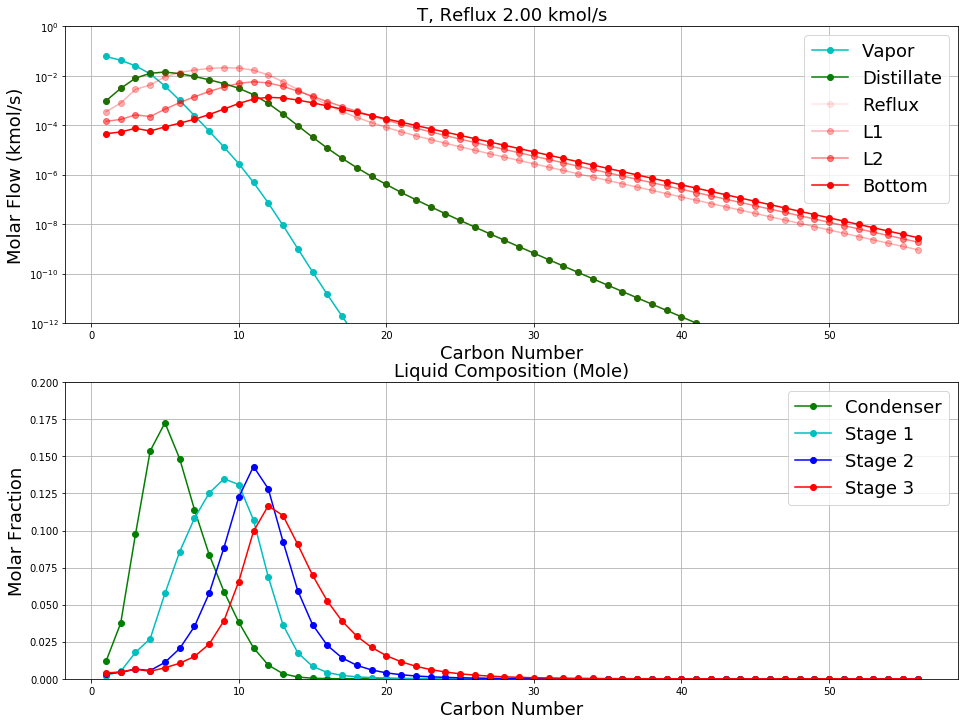

In [33]:
plot_distribution(20,523.15)